## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [52]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import time


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [53]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)


def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train() # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            y_pred = model.forward(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            ep_train_loss.append(loss.item())

        model.eval() # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                # compute predictions
                y_pred = model.forward(X_batch)
                loss = loss_fn(y_pred, y_batch)
                ep_val_loss.append(loss.item())
                y_pred = y_pred.max(dim=1)[1]
                ep_val_accuracy.append((y_pred == y_batch).cpu().detach().numpy().mean())

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy


def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

Directory fmnist already exists!


In [4]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [24]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [25]:
len(fmnist_dataset_test)

10000

In [26]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [71]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, num_classes),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [72]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
       BatchNorm1d-3                  [-1, 128]             256
              ReLU-4                  [-1, 128]               0
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 32]           4,128
       BatchNorm1d-7                   [-1, 32]              64
              ReLU-8                   [-1, 32]               0
            Linear-9                   [-1, 10]             330
Total params: 105,258
Trainable params: 105,258
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.40
Estimated Total Size (MB): 0.42
-------------------------------------------

Your experiments come here:

In [73]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here

In [74]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 7.849s
	  training loss: 0.733907
	validation loss: 0.448816
	validation accuracy: 0.843
Epoch 2 of 30 took 8.364s
	  training loss: 0.451755
	validation loss: 0.407391
	validation accuracy: 0.851
Epoch 3 of 30 took 7.665s
	  training loss: 0.412330
	validation loss: 0.366279
	validation accuracy: 0.867
Epoch 4 of 30 took 7.713s
	  training loss: 0.392726
	validation loss: 0.366012
	validation accuracy: 0.868
Epoch 5 of 30 took 8.107s
	  training loss: 0.373182
	validation loss: 0.356776
	validation accuracy: 0.870
Epoch 6 of 30 took 7.692s
	  training loss: 0.362581
	validation loss: 0.362455
	validation accuracy: 0.867
Epoch 7 of 30 took 7.647s
	  training loss: 0.355399
	validation loss: 0.336233
	validation accuracy: 0.879
Epoch 8 of 30 took 7.669s
	  training loss: 0.346220
	validation loss: 0.336716
	validation accuracy: 0.880
Epoch 9 of 30 took 7.586s
	  training loss: 0.335053
	validation loss: 0.334185
	validation accuracy: 0.877
Epoch 10 of 30 took 7.689s
	

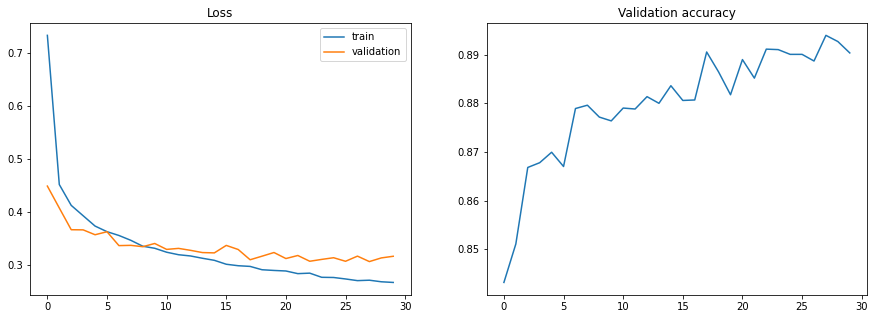

In [75]:
plot_train_process(train_loss, val_loss, val_accuracy)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [111]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 8192),
            nn.ReLU(),
            nn.Linear(8192, 8192),
            nn.ReLU(),
            nn.Linear(8192, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Linear(2048, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [112]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 8192]       6,430,720
              ReLU-3                 [-1, 8192]               0
            Linear-4                 [-1, 8192]      67,117,056
              ReLU-5                 [-1, 8192]               0
            Linear-6                 [-1, 4096]      33,558,528
              ReLU-7                 [-1, 4096]               0
            Linear-8                 [-1, 4096]      16,781,312
              ReLU-9                 [-1, 4096]               0
           Linear-10                 [-1, 2048]       8,390,656
             ReLU-11                 [-1, 2048]               0
           Linear-12                   [-1, 10]          20,490
Total params: 132,298,762
Trainable params: 132,298,762
Non-trainable params: 0
-----------------------

In [113]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here

In [114]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 36.664s
	  training loss: 0.628532
	validation loss: 0.483644
	validation accuracy: 0.833
Epoch 2 of 30 took 35.778s
	  training loss: 0.400437
	validation loss: 0.391293
	validation accuracy: 0.865
Epoch 3 of 30 took 35.669s
	  training loss: 0.353608
	validation loss: 0.393631
	validation accuracy: 0.864
Epoch 4 of 30 took 35.548s
	  training loss: 0.331587
	validation loss: 0.370806
	validation accuracy: 0.861
Epoch 5 of 30 took 35.473s
	  training loss: 0.307972
	validation loss: 0.373105
	validation accuracy: 0.870
Epoch 6 of 30 took 35.527s
	  training loss: 0.290673
	validation loss: 0.338328
	validation accuracy: 0.881
Epoch 7 of 30 took 35.504s
	  training loss: 0.277725
	validation loss: 0.338135
	validation accuracy: 0.880
Epoch 8 of 30 took 35.643s
	  training loss: 0.266779
	validation loss: 0.359890
	validation accuracy: 0.874
Epoch 9 of 30 took 35.533s
	  training loss: 0.258063
	validation loss: 0.343745
	validation accuracy: 0.888
Epoch 10 of 30 took

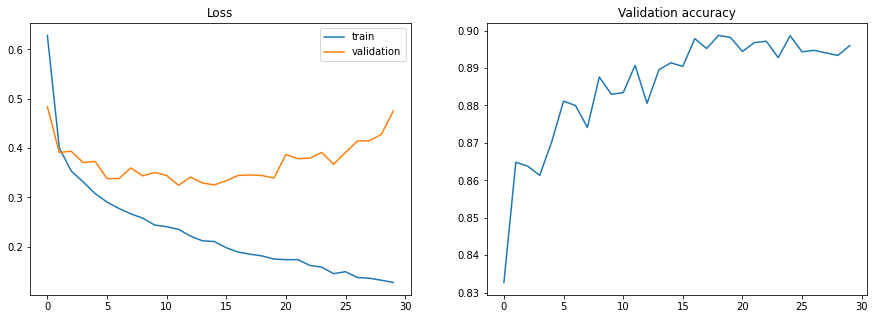

In [115]:
plot_train_process(train_loss, val_loss, val_accuracy)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [122]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Dropout(0.5),
            nn.Linear(input_shape, 8192),
            nn.BatchNorm1d(8192),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(8192, 8192),
            nn.BatchNorm1d(8192),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(8192, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Linear(2048, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [123]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Dropout-2                  [-1, 784]               0
            Linear-3                 [-1, 8192]       6,430,720
       BatchNorm1d-4                 [-1, 8192]          16,384
              ReLU-5                 [-1, 8192]               0
           Dropout-6                 [-1, 8192]               0
            Linear-7                 [-1, 8192]      67,117,056
       BatchNorm1d-8                 [-1, 8192]          16,384
              ReLU-9                 [-1, 8192]               0
          Dropout-10                 [-1, 8192]               0
           Linear-11                 [-1, 4096]      33,558,528
      BatchNorm1d-12                 [-1, 4096]           8,192
             ReLU-13                 [-1, 4096]               0
          Dropout-14                 [-

In [124]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here

In [125]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 37.390s
	  training loss: 0.632628
	validation loss: 0.479244
	validation accuracy: 0.825
Epoch 2 of 30 took 36.729s
	  training loss: 0.528381
	validation loss: 0.437074
	validation accuracy: 0.838
Epoch 3 of 30 took 36.883s
	  training loss: 0.494353
	validation loss: 0.421313
	validation accuracy: 0.844
Epoch 4 of 30 took 36.632s
	  training loss: 0.475335
	validation loss: 0.427695
	validation accuracy: 0.845
Epoch 5 of 30 took 36.669s
	  training loss: 0.462638
	validation loss: 0.378949
	validation accuracy: 0.860
Epoch 6 of 30 took 36.743s
	  training loss: 0.449669
	validation loss: 0.392300
	validation accuracy: 0.858
Epoch 7 of 30 took 36.684s
	  training loss: 0.435512
	validation loss: 0.376925
	validation accuracy: 0.858
Epoch 8 of 30 took 36.895s
	  training loss: 0.427265
	validation loss: 0.369677
	validation accuracy: 0.865
Epoch 9 of 30 took 36.817s
	  training loss: 0.423688
	validation loss: 0.361475
	validation accuracy: 0.867
Epoch 10 of 30 took

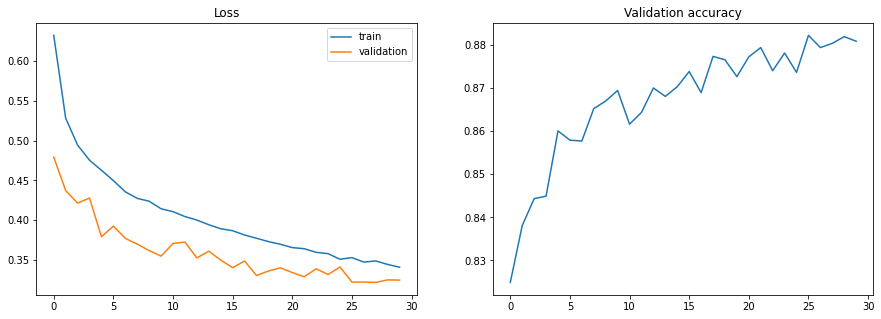

In [126]:
plot_train_process(train_loss, val_loss, val_accuracy)

### Conclusions:
_Write down small report with your conclusions and your ideas._

1. Dropout was added since model tended to become a little bit overfitted
2. Despite the fact that the validation accuracy plot doesn't seem to be overfitted, the train loss and validation loss have significant gap. Also, validation loss has become to increase.
3. Despite the fact that validation accuracy less than using overfitted NN, this model is better. Since we can increase number of epochs and get the better result.